In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.9.0 keras==2.9.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 269.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorflow-estimat

In [ ]:
import numpy as np
from keras.datasets import mnist
import cv2
import os

# Load the MNIST dataset
(x_train, y_train), (_, _) = mnist.load_data()

# Create directories for hr (high-resolution) and lr (low-resolution) images
output_dir_hr = '/content/mnist_hr'
output_dir_lr = '/content/mnist_lr'

if not os.path.exists(output_dir_hr):
    os.makedirs(output_dir_hr)

if not os.path.exists(output_dir_lr):
    os.makedirs(output_dir_lr)

# Select 10 images, one for each digit (0-9)
selected_images = {i: False for i in range(10)}

for i, (img, label) in enumerate(zip(x_train, y_train)):
    if not selected_images[label]:
        # Resize image for HR (128x128) and LR (32x32)
        hr_image = cv2.resize(img, (128, 128))  # High-resolution version
        lr_image = cv2.resize(hr_image, (32, 32))  # Low-resolution version

        # Save the images in respective directories with digit labels
        hr_path = os.path.join(output_dir_hr, f"hr_image_{label}.png")
        lr_path = os.path.join(output_dir_lr, f"lr_image_{label}.png")

        cv2.imwrite(hr_path, hr_image)
        cv2.imwrite(lr_path, lr_image)

        # Mark this digit as selected
        selected_images[label] = True

    # Break the loop once 10 images are selected (one for each digit)
    if all(selected_images.values()):
        break

print("Created HR and LR folders with 10 images, one for each digit (0-9).")


11490434/11490434 [==============================] - 0s 0us/step
Created HR and LR folders with 10 images, one for each digit (0-9).


In [ ]:
!pip install tensorflow keras opencv-python tqdm


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Conv2D, PReLU, BatchNormalization, UpSampling2D, Input, add, LeakyReLU, Dense, Flatten
from keras.applications import VGG19
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Set directories for dataset
lr_dir = '/content/mnist_lr'
hr_dir = '/content/mnist_hr'

# Load Set14 dataset
def load_mnist_data(lr_dir, hr_dir, img_size=(128, 128)):
    lr_images = []
    hr_images = []

    # Ensure consistent image naming: use f-string formatting and digit label
    for i in range(10):  # Assuming 10 images (0-9)
        hr_img_name = f"hr_image_{i}.png"
        lr_img_name = f"lr_image_{i}.png"

        hr_img_path = os.path.join(hr_dir, hr_img_name)
        lr_img_path = os.path.join(lr_dir, lr_img_name)

        hr_img = cv2.imread(hr_img_path)
        lr_img = cv2.imread(lr_img_path)

        if hr_img is not None and lr_img is not None:
            hr_img = cv2.resize(hr_img, img_size)
            lr_img = cv2.resize(lr_img, (img_size[0]//4, img_size[1]//4))

            hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
            lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)

            hr_images.append(hr_img / 255.0)
            lr_images.append(lr_img / 255.0)
        else:
            print(f"Warning: Could not load images for digit {i}: HR - {hr_img_path}, LR - {lr_img_path}")

    return np.array(lr_images), np.array(hr_images)

lr_images, hr_images = load_mnist_data(lr_dir, hr_dir)

# Split dataset into training and testing
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.2, random_state=42)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
# Generator and Discriminator setup
def res_block(x):
    res_model = Conv2D(64, (3, 3), padding="same")(x)
    res_model = BatchNormalization()(res_model)
    res_model = PReLU(shared_axes=[1, 2])(res_model)
    res_model = Conv2D(64, (3, 3), padding="same")(res_model)
    res_model = BatchNormalization()(res_model)
    return add([x, res_model])

def upscale_block(x):
    up_model = Conv2D(256, (3, 3), padding="same")(x)
    up_model = UpSampling2D(size=2)(up_model)
    up_model = PReLU(shared_axes=[1, 2])(up_model)
    return up_model

def create_gen(gen_input, num_res_block=16):
    x = Conv2D(64, (9, 9), padding="same")(gen_input)
    x = PReLU(shared_axes=[1, 2])(x)

    temp = x

    for _ in range(num_res_block):
        x = res_block(x)

    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = add([x, temp])

    x = upscale_block(x)
    x = upscale_block(x)

    output = Conv2D(3, (9, 9), padding="same", activation='tanh')(x)

    return Model(gen_input, output)

def create_disc(disc_input):
    df = 64
    x = Conv2D(df, (3, 3), strides=2, padding="same")(disc_input)
    x = LeakyReLU(alpha=0.2)(x)

    for _ in range(3):
        df *= 2
        x = Conv2D(df, (3, 3), strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model(disc_input, output)

def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
    vgg.trainable = False
    return Model(vgg.inputs, vgg.layers[10].output)

# Optimized training code with checkpoints and dynamic LR
def create_comb(gen_model, disc_model, vgg, lr_input, hr_input):
    gen_output = gen_model(lr_input)
    gen_features = vgg(gen_output)

    disc_model.trainable = False
    validity = disc_model(gen_output)

    return Model([lr_input, hr_input], [validity, gen_features])

lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])

lr_input = Input(shape=lr_shape)
hr_input = Input(shape=hr_shape)

generator = create_gen(lr_input)
discriminator = create_disc(hr_input)
vgg = build_vgg(hr_shape)

# Compile models
discriminator.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
gan_model = create_comb(generator, discriminator, vgg, lr_input, hr_input)
gan_model.compile(optimizer=Adam(learning_rate=1e-4), loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1])

# Callbacks
lr_schedule = ReduceLROnPlateau(monitor='g_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-6)
# Changed 'period' to 'save_freq' and set it to '5 epochs' to save every 5 epochs.
model_checkpoint = ModelCheckpoint('generator_set14.keras', save_freq=5)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# Train the SRGAN
epochs = 500
batch_size = 1

for epoch in range(epochs):
    for i in tqdm(range(len(lr_train))):
        lr_batch = np.expand_dims(lr_train[i], axis=0)
        hr_batch = np.expand_dims(hr_train[i], axis=0)

        fake_images = generator.predict(lr_batch)
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(hr_batch, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        vgg_features = vgg.predict(hr_batch)
        g_loss = gan_model.train_on_batch([lr_batch, hr_batch], [real_labels, vgg_features])

    print(f'Epoch {epoch+1}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}')

    if epochs % 10 == 0:
        generator.save(f'/content/drive/MyDrive/path_to_save_mnist/generator_model_epoch_{epoch}.h5')
        print(f"Model saved at epoch {epoch}")


In [ ]:
from keras.models import load_model

# Load the pre-trained generator model from epoch 100
generator = load_model('/content/generator_model_epoch_160.h5', compile=False)

# Set the number of additional epochs to run
additional_epochs = 200
batch_size = 1

# Function to continue training
def resume_training(generator, discriminator, gan_model, lr_train, hr_train, initial_epoch, additional_epochs, batch_size=1, save_interval=10):
    for epoch in range(initial_epoch, initial_epoch + additional_epochs):
        for i in tqdm(range(len(lr_train))):
            lr_batch = np.expand_dims(lr_train[i], axis=0)
            hr_batch = np.expand_dims(hr_train[i], axis=0)

            fake_images = generator.predict(lr_batch)
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(hr_batch, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator
            vgg_features = vgg.predict(hr_batch)
            g_loss = gan_model.train_on_batch([lr_batch, hr_batch], [real_labels, vgg_features])

        print(f'Epoch {epoch + 1}/{initial_epoch + additional_epochs}, D Loss: {d_loss}, G Loss: {g_loss}')

        # Save the generator model every 'save_interval' epochs
        if (epoch + 1) % save_interval == 0:
            generator.save(f'/content/drive/MyDrive/path_to_save_new/generator_model_epoch_{epoch + 1}.h5')
            print(f"Model saved at epoch {epoch + 1}")

# Resume training from epoch 100 and run for additional 50 epochs
resume_training(generator, discriminator, gan_model, lr_train, hr_train, initial_epoch=160, additional_epochs=200, batch_size=batch_size, save_interval=10)


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▎        | 1/8 [00:14<01:42, 14.71s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:20<00:55,  9.27s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:25<00:37,  7.55s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:31<00:26,  6.71s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:36<00:18,  6.23s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:42<00:12,  6.04s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:47<00:05,  5.82s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:52<00:00,  6.60s/it]


Epoch 161/360, D Loss: [2.33522034 0.5       ], G Loss: [inf, 0.6865234375, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▎        | 1/8 [00:05<00:37,  5.40s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.43s/it]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.48s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.47s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.47s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.46s/it]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.47s/it]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 8/8 [00:43<00:00,  5.49s/it]


Epoch 162/360, D Loss: [15.5390625  0.5      ], G Loss: [inf, 0.61865234375, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.77s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.88s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.91s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.89s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.93s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.95s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:47<00:00,  5.93s/it]


Epoch 163/360, D Loss: [2.97087419 0.5       ], G Loss: [inf, 0.60546875, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.92s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.85s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.93s/it]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.87s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.83s/it]


Epoch 164/360, D Loss: [3.81842256 0.5       ], G Loss: [inf, 0.65966796875, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.73s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.82s/it]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.77s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.81s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.78s/it]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.81s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.79s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.79s/it]


Epoch 165/360, D Loss: [0.04292297 1.        ], G Loss: [inf, 0.64208984375, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.73s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.72s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.73s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.79s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.78s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.83s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.78s/it]


Epoch 166/360, D Loss: [0.86337388 0.5       ], G Loss: [inf, 0.51318359375, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.77s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.77s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.78s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 167/360, D Loss: [1.24121097 0.5       ], G Loss: [inf, 0.5859375, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.74s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.79s/it]


Epoch 168/360, D Loss: [0.05694583 1.        ], G Loss: [inf, 0.3427734375, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.86s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.81s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.78s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.79s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 169/360, D Loss: [2.86340714e-04 1.00000000e+00], G Loss: [inf, 0.288330078125, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.78s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 170/360, D Loss: [2.2739172e-05 1.0000000e+00], G Loss: [inf, 0.2449951171875, inf]
Model saved at epoch 170


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.84s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.78s/it]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:46<00:00,  5.82s/it]


Epoch 171/360, D Loss: [1.44541264e-05 1.00000000e+00], G Loss: [inf, 0.191162109375, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:06<00:42,  6.02s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.95s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.85s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.84s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.83s/it]


Epoch 172/360, D Loss: [1.30534172e-05 1.00000000e+00], G Loss: [inf, 0.1402587890625, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.83s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.77s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.76s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.79s/it]


Epoch 173/360, D Loss: [1.2665987e-05 1.0000000e+00], G Loss: [inf, 0.09375, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.70s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.78s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.76s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.79s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.79s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.75s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


Epoch 174/360, D Loss: [1.2665987e-05 1.0000000e+00], G Loss: [inf, 0.053436279296875, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.89s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.85s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.85s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.79s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 175/360, D Loss: [1.257658e-05 1.000000e+00], G Loss: [inf, 0.0252532958984375, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.77s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.75s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.79s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.77s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.78s/it]


Epoch 176/360, D Loss: [1.22785568e-05 1.00000000e+00], G Loss: [inf, 0.01050567626953125, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.83s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.79s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.79s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.79s/it]


Epoch 177/360, D Loss: [1.23679638e-05 1.00000000e+00], G Loss: [inf, 0.0037860870361328125, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.76s/it]

1/1 [==============================] - 0s 55ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.77s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.79s/it]


Epoch 178/360, D Loss: [1.23679638e-05 1.00000000e+00], G Loss: [inf, 0.001129150390625, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.78s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.76s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.81s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.83s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.85s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 179/360, D Loss: [1.23679638e-05 1.00000000e+00], G Loss: [inf, 0.000263214111328125, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.76s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.77s/it]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.79s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.75s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


Epoch 180/360, D Loss: [1.23679638e-05 1.00000000e+00], G Loss: [inf, 5.4776668548583984e-05, inf]
Model saved at epoch 180


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.73s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.73s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.73s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.74s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.76s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.74s/it]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:45<00:00,  5.75s/it]


Epoch 181/360, D Loss: [1.22785568e-05 1.00000000e+00], G Loss: [inf, 9.894371032714844e-06, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.82s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 182/360, D Loss: [1.20997429e-05 1.00000000e+00], G Loss: [inf, 1.7285346984863281e-06, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.69s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.80s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.76s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.75s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.76s/it]


Epoch 183/360, D Loss: [1.19805336e-05 1.00000000e+00], G Loss: [inf, 2.384185791015625e-07, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.88s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.79s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.79s/it]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 184/360, D Loss: [1.18911266e-05 1.00000000e+00], G Loss: [inf, 5.960464477539063e-08, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.70s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.75s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:22,  5.75s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.77s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.76s/it]


Epoch 185/360, D Loss: [1.18911266e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.77s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.75s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.77s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.76s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.75s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:46<00:00,  5.76s/it]


Epoch 186/360, D Loss: [1.18911266e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.70s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.78s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


Epoch 187/360, D Loss: [1.14440918e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.77s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.72s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.79s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.79s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:46<00:00,  5.78s/it]


Epoch 188/360, D Loss: [1.15334988e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.71s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.75s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.78s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.75s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.75s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.74s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 8/8 [00:45<00:00,  5.75s/it]


Epoch 189/360, D Loss: [1.16229057e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.84s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:22,  5.75s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.77s/it]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


Epoch 190/360, D Loss: [1.13546848e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]
Model saved at epoch 190


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.74s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.78s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.76s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


Epoch 191/360, D Loss: [1.11758709e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.77s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.79s/it]


Epoch 192/360, D Loss: [1.0997057e-05 1.0000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.87s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 193/360, D Loss: [1.11758709e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.70s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.77s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.78s/it]


Epoch 194/360, D Loss: [1.0997057e-05 1.0000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.87s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.77s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.75s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.77s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.75s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.76s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.78s/it]


Epoch 195/360, D Loss: [1.08480453e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.71s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.76s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.80s/it]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.76s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


Epoch 196/360, D Loss: [1.07586384e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.88s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.81s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 197/360, D Loss: [1.090765e-05 1.000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.89s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.86s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.85s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.79s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 198/360, D Loss: [1.03414059e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.91s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.81s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.78s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 199/360, D Loss: [1.03414059e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 200/360, D Loss: [1.01923943e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]
Model saved at epoch 200


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.84s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.77s/it]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.85s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 201/360, D Loss: [1.00135803e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.76s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.83s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.83s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 202/360, D Loss: [1.01029873e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 203/360, D Loss: [1.00135803e-05 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.83s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.83s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.83s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.83s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.83s/it]


Epoch 204/360, D Loss: [9.95397568e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.75s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.76s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.75s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.79s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.78s/it]


Epoch 205/360, D Loss: [9.80496407e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.91s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.88s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.83s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.83s/it]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.84s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.84s/it]


Epoch 206/360, D Loss: [9.80496407e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.73s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 207/360, D Loss: [9.56654549e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.88s/it]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.78s/it]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.79s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 208/360, D Loss: [9.65595245e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.77s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.84s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.79s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.78s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 209/360, D Loss: [9.41753387e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.77s/it]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.87s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.85s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 210/360, D Loss: [9.26852226e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]
Model saved at epoch 210


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.79s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.87s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.87s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.83s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.83s/it]


Epoch 211/360, D Loss: [9.26852226e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.81s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.79s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 212/360, D Loss: [9.05990601e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.88s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.83s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.81s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.85s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:46<00:00,  5.82s/it]


Epoch 213/360, D Loss: [9.11951065e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.79s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.83s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.79s/it]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.83s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:46<00:00,  5.81s/it]


Epoch 214/360, D Loss: [8.70227814e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.91s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.82s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.82s/it]

1/1 [==============================] - 0s 58ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.77s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.85s/it]


Epoch 215/360, D Loss: [9.00030136e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.87s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.86s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.86s/it]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.85s/it]


Epoch 216/360, D Loss: [8.7916851e-06 1.0000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.93s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.90s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.85s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.87s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.83s/it]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.84s/it]


Epoch 217/360, D Loss: [8.5234642e-06 1.0000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.86s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.84s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.88s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.85s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.84s/it]


Epoch 218/360, D Loss: [8.64267349e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.84s/it]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.87s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.86s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.84s/it]


Epoch 219/360, D Loss: [8.58306885e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.90s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.83s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.84s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.91s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.85s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.86s/it]


Epoch 220/360, D Loss: [8.58306885e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]
Model saved at epoch 220


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.82s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.80s/it]


Epoch 221/360, D Loss: [8.5234642e-06 1.0000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.85s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.80s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.89s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.85s/it]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.81s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.84s/it]


Epoch 222/360, D Loss: [8.37445259e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.74s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.86s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.78s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.82s/it]


Epoch 223/360, D Loss: [8.31484795e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.83s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.87s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.83s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:46<00:00,  5.84s/it]


Epoch 224/360, D Loss: [8.2552433e-06 1.0000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.81s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.86s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.84s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.86s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.84s/it]


Epoch 225/360, D Loss: [8.13603401e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.82s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.85s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.83s/it]

1/1 [==============================] - 0s 54ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.87s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.86s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.85s/it]


Epoch 226/360, D Loss: [8.13603401e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:06<00:42,  6.03s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.87s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.88s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.89s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.89s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.84s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:47<00:00,  5.89s/it]


Epoch 227/360, D Loss: [8.13603401e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.73s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.85s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.83s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.85s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.86s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.84s/it]


Epoch 228/360, D Loss: [8.04662704e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.91s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.90s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.86s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.90s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.87s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.85s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:46<00:00,  5.87s/it]


Epoch 229/360, D Loss: [7.80820847e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.82s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.98s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.92s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.95s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.91s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.93s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.88s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:47<00:00,  5.91s/it]


Epoch 230/360, D Loss: [7.62939453e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]
Model saved at epoch 230


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.85s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.87s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.89s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.87s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.90s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 8/8 [00:46<00:00,  5.87s/it]


Epoch 231/360, D Loss: [7.62939453e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.98s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.87s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.86s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.84s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.87s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.90s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.87s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:47<00:00,  5.88s/it]


Epoch 232/360, D Loss: [7.62939453e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.82s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.86s/it]

1/1 [==============================] - 0s 54ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.88s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.88s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.89s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.87s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.87s/it]


Epoch 233/360, D Loss: [7.51018524e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.92s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.85s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.91s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.89s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.91s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.87s/it]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.90s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:47<00:00,  5.90s/it]


Epoch 234/360, D Loss: [7.4505806e-06 1.0000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.91s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.89s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.85s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.90s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.87s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.91s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:47<00:00,  5.88s/it]


Epoch 235/360, D Loss: [7.39097595e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.87s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.85s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.83s/it]

1/1 [==============================] - 0s 55ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.86s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.84s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.87s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.85s/it]


Epoch 236/360, D Loss: [7.33137131e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:06<00:42,  6.04s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.93s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.93s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.89s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:35<00:11,  5.89s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:41<00:05,  5.85s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:47<00:00,  5.89s/it]


Epoch 237/360, D Loss: [7.33137131e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.84s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:35,  5.90s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.84s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.86s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.80s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.82s/it]


Epoch 238/360, D Loss: [7.27176666e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.93s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.83s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.86s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:29<00:17,  5.83s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.82s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.81s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.83s/it]


Epoch 239/360, D Loss: [7.06315041e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.72s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.83s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.77s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.77s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.77s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.76s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:46<00:00,  5.77s/it]


Epoch 240/360, D Loss: [7.00354576e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]
Model saved at epoch 240


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:41,  5.88s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.81s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:29,  5.82s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:23<00:23,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.77s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.73s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:40<00:05,  5.74s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:46<00:00,  5.75s/it]


Epoch 241/360, D Loss: [7.00354576e-06 1.00000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.69s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.75s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.69s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.74s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.68s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.70s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.71s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 8/8 [00:45<00:00,  5.70s/it]


Epoch 242/360, D Loss: [6.7949295e-06 1.0000000e+00], G Loss: [inf, 0.0, inf]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.77s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.68s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.68s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.68s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.68s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.67s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.66s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:45<00:00,  5.69s/it]


Epoch 243/360, D Loss: [6.58631325e-06 1.00000000e+00], G Loss: [51.125, 0.0, 51.125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.63s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.77s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.72s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.72s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.67s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.65s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.66s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:45<00:00,  5.67s/it]


Epoch 244/360, D Loss: [6.5267086e-06 1.0000000e+00], G Loss: [42.75, 0.0, 42.75]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.73s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.60s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.62s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.66s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.65s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:45<00:00,  5.64s/it]


Epoch 245/360, D Loss: [6.5267086e-06 1.0000000e+00], G Loss: [34.625, 0.0, 34.625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.60s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


Epoch 246/360, D Loss: [6.43730164e-06 1.00000000e+00], G Loss: [28.53125, 0.0, 28.53125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.54s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.55s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.52s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


Epoch 247/360, D Loss: [6.37769699e-06 1.00000000e+00], G Loss: [24.9375, 0.0, 24.9375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.47s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.51s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.53s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.52s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]


Epoch 248/360, D Loss: [6.49690628e-06 1.00000000e+00], G Loss: [20.4375, 0.0, 20.4375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.57s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.55s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.53s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.69s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.59s/it]


Epoch 249/360, D Loss: [6.34789467e-06 1.00000000e+00], G Loss: [17.78125, 0.0, 17.78125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:32,  5.50s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.54s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.47s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.49s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.51s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.50s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]


Epoch 250/360, D Loss: [6.28829002e-06 1.00000000e+00], G Loss: [14.578125, 0.0, 14.578125]
Model saved at epoch 250


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:37,  5.41s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.50s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.47s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.48s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.45s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.47s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:43<00:00,  5.47s/it]


Epoch 251/360, D Loss: [6.28829002e-06 1.00000000e+00], G Loss: [13.5, 0.0, 13.5]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.46s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.45s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.45s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.43s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.45s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.43s/it]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 8/8 [00:43<00:00,  5.45s/it]


Epoch 252/360, D Loss: [6.28829002e-06 1.00000000e+00], G Loss: [11.7890625, 0.0, 11.7890625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:37,  5.40s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.38s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.43s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.41s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.45s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.44s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.44s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:43<00:00,  5.44s/it]


Epoch 253/360, D Loss: [6.28829002e-06 1.00000000e+00], G Loss: [9.484375, 0.0, 9.484375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.44s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.54s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.47s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.46s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.45s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.42s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.47s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:43<00:00,  5.46s/it]


Epoch 254/360, D Loss: [6.07967377e-06 1.00000000e+00], G Loss: [7.4609375, 0.0, 7.4609375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:32,  5.49s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.46s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.45s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.47s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.45s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:43<00:00,  5.47s/it]


Epoch 255/360, D Loss: [5.90085983e-06 1.00000000e+00], G Loss: [4.875, 1.1920928955078125e-07, 4.875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.44s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.42s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.49s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.46s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.48s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.46s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:43<00:00,  5.47s/it]


Epoch 256/360, D Loss: [5.90085983e-06 1.00000000e+00], G Loss: [3.55078125, 5.960464477539063e-08, 3.55078125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:37,  5.37s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.45s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.44s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.47s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.44s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.47s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:43<00:00,  5.45s/it]


Epoch 257/360, D Loss: [5.9902668e-06 1.0000000e+00], G Loss: [3.005859375, 1.1920928955078125e-07, 3.005859375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.49s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.46s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.45s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.48s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.46s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.47s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:43<00:00,  5.48s/it]


Epoch 258/360, D Loss: [5.78165054e-06 1.00000000e+00], G Loss: [2.69921875, 1.7881393432617188e-07, 2.69921875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.50s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.49s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.46s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.47s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.49s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:43<00:00,  5.49s/it]


Epoch 259/360, D Loss: [5.81145287e-06 1.00000000e+00], G Loss: [2.796875, 2.384185791015625e-07, 2.796875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:37,  5.40s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.47s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.46s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.48s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.46s/it]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.49s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:43<00:00,  5.47s/it]


Epoch 260/360, D Loss: [5.81145287e-06 1.00000000e+00], G Loss: [3.615234375, 3.5762786865234375e-07, 3.615234375]
Model saved at epoch 260


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.52s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.51s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.47s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.51s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.47s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.50s/it]


Epoch 261/360, D Loss: [5.69224358e-06 1.00000000e+00], G Loss: [2.203125, 4.172325134277344e-07, 2.203125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.45s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.46s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.49s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.46s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.52s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:43<00:00,  5.48s/it]


Epoch 262/360, D Loss: [5.60283661e-06 1.00000000e+00], G Loss: [2.841796875, 4.172325134277344e-07, 2.841796875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:37,  5.40s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.50s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.48s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.50s/it]


Epoch 263/360, D Loss: [5.54323196e-06 1.00000000e+00], G Loss: [2.302734375, 4.172325134277344e-07, 2.302734375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.66s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.51s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:21,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.49s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:10,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.51s/it]


Epoch 264/360, D Loss: [5.69224358e-06 1.00000000e+00], G Loss: [1.861328125, 4.172325134277344e-07, 1.861328125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.47s/it]

1/1 [==============================] - 0s 53ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.47s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.49s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.50s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:43<00:00,  5.50s/it]


Epoch 265/360, D Loss: [5.63263893e-06 1.00000000e+00], G Loss: [1.7021484375, 5.364418029785156e-07, 1.7021484375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.46s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.49s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.52s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.49s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:32<00:10,  5.47s/it]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.50s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:43<00:00,  5.50s/it]


Epoch 266/360, D Loss: [5.54323196e-06 1.00000000e+00], G Loss: [1.66015625, 5.960464477539062e-07, 1.66015625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.51s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.51s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.49s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]


Epoch 267/360, D Loss: [5.51342964e-06 1.00000000e+00], G Loss: [1.529296875, 6.556510925292969e-07, 1.529296875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.44s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:10<00:33,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:21<00:22,  5.50s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.56s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


Epoch 268/360, D Loss: [5.33461571e-06 1.00000000e+00], G Loss: [1.421875, 7.152557373046875e-07, 1.421875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.48s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.53s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.51s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.52s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]


Epoch 269/360, D Loss: [5.33461571e-06 1.00000000e+00], G Loss: [1.546875, 8.344650268554688e-07, 1.546875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.43s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:21<00:21,  5.48s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:32<00:11,  5.51s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]


Epoch 270/360, D Loss: [5.24520874e-06 1.00000000e+00], G Loss: [1.3056640625, 8.344650268554688e-07, 1.3056640625]
Model saved at epoch 270


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.47s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:10,  5.48s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.55s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


Epoch 271/360, D Loss: [5.1856041e-06 1.0000000e+00], G Loss: [1.3681640625, 1.0132789611816406e-06, 1.3681640625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.55s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.52s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.54s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.55s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.51s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


Epoch 272/360, D Loss: [5.1856041e-06 1.0000000e+00], G Loss: [1.50390625, 1.2516975402832031e-06, 1.50390625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:37,  5.42s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.45s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.54s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.56s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


Epoch 273/360, D Loss: [5.09619713e-06 1.00000000e+00], G Loss: [1.123046875, 1.2516975402832031e-06, 1.123046875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.50s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.52s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


Epoch 274/360, D Loss: [4.97698784e-06 1.00000000e+00], G Loss: [1.53125, 1.0728836059570312e-06, 1.53125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.52s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.50s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.46s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 8/8 [00:44<00:00,  5.50s/it]


Epoch 275/360, D Loss: [4.88758087e-06 1.00000000e+00], G Loss: [1.154296875, 1.3709068298339844e-06, 1.154296875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.43s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.48s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.51s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.53s/it]


Epoch 276/360, D Loss: [4.85777855e-06 1.00000000e+00], G Loss: [1.314453125, 2.0265579223632812e-06, 1.314453125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.57s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.52s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.52s/it]


Epoch 277/360, D Loss: [4.82797623e-06 1.00000000e+00], G Loss: [1.1328125, 1.9669532775878906e-06, 1.1328125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.52s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.51s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


Epoch 278/360, D Loss: [4.7981739e-06 1.0000000e+00], G Loss: [1.12890625, 1.6689300537109375e-06, 1.12890625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.55s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.52s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.56s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.52s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


Epoch 279/360, D Loss: [4.82797623e-06 1.00000000e+00], G Loss: [1.0771484375, 1.9073486328125e-06, 1.0771484375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.55s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.54s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.53s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.54s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.52s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


Epoch 280/360, D Loss: [4.76837158e-06 1.00000000e+00], G Loss: [0.9951171875, 2.4437904357910156e-06, 0.9951171875]
Model saved at epoch 280


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.51s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.49s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.55s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.55s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.57s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


Epoch 281/360, D Loss: [4.73856926e-06 1.00000000e+00], G Loss: [0.95654296875, 2.562999725341797e-06, 0.95654296875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.47s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.55s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.54s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.54s/it]


Epoch 282/360, D Loss: [4.70876694e-06 1.00000000e+00], G Loss: [0.958984375, 2.384185791015625e-06, 0.958984375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.66s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.55s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.56s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.51s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


Epoch 283/360, D Loss: [4.58955765e-06 1.00000000e+00], G Loss: [0.8544921875, 2.562999725341797e-06, 0.8544921875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.46s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.56s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.54s/it]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


Epoch 284/360, D Loss: [4.55975533e-06 1.00000000e+00], G Loss: [0.86767578125, 3.2186508178710938e-06, 0.86767578125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.54s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.52s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.55s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.53s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


Epoch 285/360, D Loss: [4.44054604e-06 1.00000000e+00], G Loss: [0.8251953125, 3.337860107421875e-06, 0.8251953125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.52s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.54s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.55s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.54s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.55s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


Epoch 286/360, D Loss: [4.44054604e-06 1.00000000e+00], G Loss: [0.76318359375, 3.516674041748047e-06, 0.76318359375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.55s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 54ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.56s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


Epoch 287/360, D Loss: [4.44054604e-06 1.00000000e+00], G Loss: [0.8154296875, 3.7550926208496094e-06, 0.8154296875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.52s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:10<00:32,  5.49s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.55s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.53s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.55s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.54s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


Epoch 288/360, D Loss: [4.35113907e-06 1.00000000e+00], G Loss: [0.7783203125, 4.410743713378906e-06, 0.7783203125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.66s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.69s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.65s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.60s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.55s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


Epoch 289/360, D Loss: [4.29153442e-06 1.00000000e+00], G Loss: [0.69921875, 4.708766937255859e-06, 0.69921875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


Epoch 290/360, D Loss: [4.20212746e-06 1.00000000e+00], G Loss: [0.767578125, 4.827976226806641e-06, 0.767578125]
Model saved at epoch 290


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.50s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.55s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.54s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.56s/it]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


Epoch 291/360, D Loss: [4.23192978e-06 1.00000000e+00], G Loss: [0.6845703125, 5.066394805908203e-06, 0.6845703125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.63s/it]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.56s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.56s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.54s/it]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


Epoch 292/360, D Loss: [4.17232513e-06 1.00000000e+00], G Loss: [0.70166015625, 6.079673767089844e-06, 0.70166015625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.55s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.57s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.56s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.52s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.55s/it]


Epoch 293/360, D Loss: [4.14252281e-06 1.00000000e+00], G Loss: [0.75341796875, 6.139278411865234e-06, 0.75341796875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.78s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.66s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.59s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 294/360, D Loss: [4.05311584e-06 1.00000000e+00], G Loss: [0.62451171875, 5.9604644775390625e-06, 0.62451171875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 295/360, D Loss: [3.96370888e-06 1.00000000e+00], G Loss: [0.85302734375, 6.67572021484375e-06, 0.85302734375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.55s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.58s/it]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


Epoch 296/360, D Loss: [3.96370888e-06 1.00000000e+00], G Loss: [0.58642578125, 8.344650268554688e-06, 0.58642578125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.65s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.56s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.55s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:44<00:00,  5.59s/it]


Epoch 297/360, D Loss: [3.9935112e-06 1.0000000e+00], G Loss: [0.84912109375, 8.52346420288086e-06, 0.84912109375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.48s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.56s/it]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


Epoch 298/360, D Loss: [3.87430191e-06 1.00000000e+00], G Loss: [0.748046875, 7.927417755126953e-06, 0.748046875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.68s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.60s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.58s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 299/360, D Loss: [3.90410423e-06 1.00000000e+00], G Loss: [0.7333984375, 7.808208465576172e-06, 0.7333984375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.53s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.55s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


Epoch 300/360, D Loss: [3.84449959e-06 1.00000000e+00], G Loss: [0.7275390625, 8.64267349243164e-06, 0.7275390625]
Model saved at epoch 300


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.64s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.56s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.65s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 301/360, D Loss: [3.84449959e-06 1.00000000e+00], G Loss: [0.77001953125, 1.0073184967041016e-05, 0.77001953125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.53s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.54s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.56s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:38<00:05,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


Epoch 302/360, D Loss: [3.75509262e-06 1.00000000e+00], G Loss: [0.759765625, 1.1146068572998047e-05, 0.759765625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.58s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.60s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.59s/it]


Epoch 303/360, D Loss: [3.75509262e-06 1.00000000e+00], G Loss: [0.751953125, 1.2636184692382812e-05, 0.751953125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.64s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.66s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.68s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 304/360, D Loss: [3.7252903e-06 1.0000000e+00], G Loss: [0.76806640625, 1.0967254638671875e-05, 0.76806640625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.55s/it]

1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


Epoch 305/360, D Loss: [3.69548798e-06 1.00000000e+00], G Loss: [0.662109375, 1.0609626770019531e-05, 0.662109375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


Epoch 306/360, D Loss: [3.69548798e-06 1.00000000e+00], G Loss: [0.8515625, 1.2099742889404297e-05, 0.8515625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.50s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.57s/it]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.59s/it]


Epoch 307/360, D Loss: [3.66568565e-06 1.00000000e+00], G Loss: [0.61669921875, 1.5079975128173828e-05, 0.61669921875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.70s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.60s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.60s/it]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 308/360, D Loss: [3.57627869e-06 1.00000000e+00], G Loss: [0.849609375, 1.4722347259521484e-05, 0.849609375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.55s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.67s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.68s/it]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.66s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 309/360, D Loss: [3.51667404e-06 1.00000000e+00], G Loss: [0.60107421875, 1.3649463653564453e-05, 0.60107421875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.67s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 310/360, D Loss: [3.48687172e-06 1.00000000e+00], G Loss: [0.6865234375, 1.519918441772461e-05, 0.6865234375]
Model saved at epoch 310


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.50s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.58s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 311/360, D Loss: [3.39746475e-06 1.00000000e+00], G Loss: [0.5537109375, 1.8358230590820312e-05, 0.5537109375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.55s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.56s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.57s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:44<00:00,  5.59s/it]


Epoch 312/360, D Loss: [3.39746475e-06 1.00000000e+00], G Loss: [0.630859375, 1.8477439880371094e-05, 0.630859375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.53s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.57s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.56s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.57s/it]


Epoch 313/360, D Loss: [3.39746475e-06 1.00000000e+00], G Loss: [0.63720703125, 1.9669532775878906e-05, 0.63720703125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.56s/it]

1/1 [==============================] - 0s 115ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.65s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.67s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.60s/it]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.62s/it]


Epoch 314/360, D Loss: [3.36766243e-06 1.00000000e+00], G Loss: [0.5400390625, 2.0802021026611328e-05, 0.5400390625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


Epoch 315/360, D Loss: [3.27825546e-06 1.00000000e+00], G Loss: [0.67529296875, 1.7642974853515625e-05, 0.67529296875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.67s/it]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.58s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.57s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 316/360, D Loss: [3.27825546e-06 1.00000000e+00], G Loss: [0.51611328125, 1.9669532775878906e-05, 0.51611328125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.49s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.57s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.60s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


Epoch 317/360, D Loss: [3.30805779e-06 1.00000000e+00], G Loss: [0.73095703125, 2.8431415557861328e-05, 0.73095703125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.57s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.58s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 318/360, D Loss: [3.21865082e-06 1.00000000e+00], G Loss: [0.53564453125, 3.11732292175293e-05, 0.53564453125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.54s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.62s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.69s/it]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.66s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:45<00:00,  5.64s/it]


Epoch 319/360, D Loss: [3.24845314e-06 1.00000000e+00], G Loss: [0.65478515625, 2.110004425048828e-05, 0.65478515625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.64s/it]

1/1 [==============================] - 0s 54ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.59s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.59s/it]


Epoch 320/360, D Loss: [3.24845314e-06 1.00000000e+00], G Loss: [0.576171875, 2.1457672119140625e-05, 0.576171875]
Model saved at epoch 320


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.63s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 321/360, D Loss: [3.12924385e-06 1.00000000e+00], G Loss: [0.5390625, 2.9981136322021484e-05, 0.5390625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.57s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


Epoch 322/360, D Loss: [3.09944153e-06 1.00000000e+00], G Loss: [0.56005859375, 3.3974647521972656e-05, 0.56005859375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.66s/it]

1/1 [==============================] - 0s 48ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.69s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:44<00:00,  5.62s/it]


Epoch 323/360, D Loss: [3.03983688e-06 1.00000000e+00], G Loss: [0.468994140625, 2.7120113372802734e-05, 0.468994140625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.63s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 324/360, D Loss: [3.03983688e-06 1.00000000e+00], G Loss: [0.4560546875, 2.7298927307128906e-05, 0.4560546875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.70s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.62s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.63s/it]

1/1 [==============================] - 0s 48ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.64s/it]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.76s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.69s/it]

1/1 [==============================] - 0s 62ms/step


100%|██████████| 8/8 [00:45<00:00,  5.68s/it]


Epoch 325/360, D Loss: [2.95042992e-06 1.00000000e+00], G Loss: [0.47265625, 3.707408905029297e-05, 0.47265625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.66s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.63s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.63s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.58s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 326/360, D Loss: [2.95042992e-06 1.00000000e+00], G Loss: [0.431396484375, 3.7610530853271484e-05, 0.431396484375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.57s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.63s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.64s/it]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:45<00:00,  5.63s/it]


Epoch 327/360, D Loss: [2.89082527e-06 1.00000000e+00], G Loss: [0.433837890625, 3.349781036376953e-05, 0.433837890625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.66s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.63s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.61s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.66s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:45<00:00,  5.63s/it]


Epoch 328/360, D Loss: [2.89082527e-06 1.00000000e+00], G Loss: [0.47314453125, 3.6776065826416016e-05, 0.47314453125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.67s/it]

1/1 [==============================] - 0s 54ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.67s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.64s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.64s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.65s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:45<00:00,  5.67s/it]


Epoch 329/360, D Loss: [2.8014183e-06 1.0000000e+00], G Loss: [0.393310546875, 4.1961669921875e-05, 0.393310546875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.68s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.65s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.66s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.62s/it]


Epoch 330/360, D Loss: [2.8014183e-06 1.0000000e+00], G Loss: [0.51025390625, 4.7206878662109375e-05, 0.51025390625]
Model saved at epoch 330


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.68s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.64s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.60s/it]

1/1 [==============================] - 0s 54ms/step


100%|██████████| 8/8 [00:44<00:00,  5.62s/it]


Epoch 331/360, D Loss: [2.77161598e-06 1.00000000e+00], G Loss: [0.47216796875, 4.3332576751708984e-05, 0.47216796875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.52s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.62s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.62s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 332/360, D Loss: [2.74181366e-06 1.00000000e+00], G Loss: [0.47265625, 3.886222839355469e-05, 0.47265625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.66s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.62s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 333/360, D Loss: [2.74181366e-06 1.00000000e+00], G Loss: [0.505859375, 4.297494888305664e-05, 0.505859375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.62s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 334/360, D Loss: [2.74181366e-06 1.00000000e+00], G Loss: [0.50634765625, 6.0617923736572266e-05, 0.50634765625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.74s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.63s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:45<00:00,  5.63s/it]


Epoch 335/360, D Loss: [2.71201134e-06 1.00000000e+00], G Loss: [0.51611328125, 4.988908767700195e-05, 0.51611328125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.63s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.60s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.63s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 336/360, D Loss: [2.65240669e-06 1.00000000e+00], G Loss: [0.55419921875, 3.916025161743164e-05, 0.55419921875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.58s/it]

1/1 [==============================] - 0s 52ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.59s/it]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.60s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 337/360, D Loss: [2.65240669e-06 1.00000000e+00], G Loss: [0.4814453125, 4.035234451293945e-05, 0.4814453125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.63s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.59s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.60s/it]


Epoch 338/360, D Loss: [2.62260437e-06 1.00000000e+00], G Loss: [0.47314453125, 5.561113357543945e-05, 0.47314453125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.53s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.59s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.62s/it]


Epoch 339/360, D Loss: [2.59280205e-06 1.00000000e+00], G Loss: [0.470947265625, 5.692243576049805e-05, 0.470947265625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.66s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.68s/it]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.71s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.65s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.67s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.63s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 8/8 [00:45<00:00,  5.65s/it]


Epoch 340/360, D Loss: [2.59280205e-06 1.00000000e+00], G Loss: [0.441650390625, 4.988908767700195e-05, 0.441650390625]
Model saved at epoch 340


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.64s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.69s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.64s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.66s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:45<00:00,  5.64s/it]


Epoch 341/360, D Loss: [2.5331974e-06 1.0000000e+00], G Loss: [0.440673828125, 4.5418739318847656e-05, 0.440673828125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.67s/it]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.65s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.70s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:45<00:00,  5.64s/it]


Epoch 342/360, D Loss: [2.50339508e-06 1.00000000e+00], G Loss: [0.408447265625, 5.608797073364258e-05, 0.408447265625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.64s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.62s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.68s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.65s/it]

1/1 [==============================] - 0s 48ms/step


100%|██████████| 8/8 [00:45<00:00,  5.64s/it]


Epoch 343/360, D Loss: [2.50339508e-06 1.00000000e+00], G Loss: [0.37158203125, 6.204843521118164e-05, 0.37158203125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.69s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.63s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.67s/it]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:45<00:00,  5.64s/it]


Epoch 344/360, D Loss: [2.50339508e-06 1.00000000e+00], G Loss: [0.423828125, 6.204843521118164e-05, 0.423828125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.57s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.68s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.75s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.70s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.67s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:45<00:00,  5.65s/it]


Epoch 345/360, D Loss: [2.50339508e-06 1.00000000e+00], G Loss: [0.34814453125, 6.204843521118164e-05, 0.34814453125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.73s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.66s/it]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.61s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:45<00:00,  5.64s/it]


Epoch 346/360, D Loss: [2.47359276e-06 1.00000000e+00], G Loss: [0.415771484375, 7.200241088867188e-05, 0.415771484375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 53ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.62s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.61s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 347/360, D Loss: [2.44379044e-06 1.00000000e+00], G Loss: [0.33935546875, 7.367134094238281e-05, 0.33935546875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.80s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.66s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.66s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.64s/it]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.63s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:45<00:00,  5.65s/it]


Epoch 348/360, D Loss: [2.38418579e-06 1.00000000e+00], G Loss: [0.404296875, 7.665157318115234e-05, 0.404296875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:34,  5.69s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.65s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.62s/it]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


100%|██████████| 8/8 [00:45<00:00,  5.63s/it]


Epoch 349/360, D Loss: [2.38418579e-06 1.00000000e+00], G Loss: [0.33251953125, 7.486343383789062e-05, 0.33251953125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.75s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.67s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.67s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:28<00:17,  5.70s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:34<00:11,  5.67s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.62s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:45<00:00,  5.66s/it]


Epoch 350/360, D Loss: [2.35438347e-06 1.00000000e+00], G Loss: [0.406982421875, 7.843971252441406e-05, 0.406982421875]
Model saved at epoch 350


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.54s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.67s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.62s/it]

1/1 [==============================] - 0s 54ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.62s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.63s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.62s/it]


Epoch 351/360, D Loss: [2.35438347e-06 1.00000000e+00], G Loss: [0.429443359375, 0.00010395050048828125, 0.429443359375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.65s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.63s/it]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.69s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.65s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.63s/it]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.61s/it]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:45<00:00,  5.64s/it]


Epoch 352/360, D Loss: [2.29477882e-06 1.00000000e+00], G Loss: [0.354736328125, 9.101629257202148e-05, 0.354736328125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.64s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.59s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.57s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.64s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 353/360, D Loss: [2.2649765e-06 1.0000000e+00], G Loss: [0.51708984375, 7.605552673339844e-05, 0.51708984375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.71s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.69s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.66s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.65s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 52ms/step


100%|██████████| 8/8 [00:45<00:00,  5.63s/it]


Epoch 354/360, D Loss: [2.23517418e-06 1.00000000e+00], G Loss: [0.420654296875, 9.608268737792969e-05, 0.420654296875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.59s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.59s/it]

1/1 [==============================] - 0s 53ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.62s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.66s/it]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.69s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:45<00:00,  5.64s/it]


Epoch 355/360, D Loss: [2.23517418e-06 1.00000000e+00], G Loss: [0.5234375, 0.00012731552124023438, 0.5234375]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.73s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.64s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:17<00:28,  5.67s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.64s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.62s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.62s/it]


Epoch 356/360, D Loss: [2.23517418e-06 1.00000000e+00], G Loss: [0.5576171875, 9.03010368347168e-05, 0.5576171875]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.56s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.59s/it]

1/1 [==============================] - 0s 52ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.59s/it]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8/8 [00:44<00:00,  5.58s/it]


Epoch 357/360, D Loss: [2.20537186e-06 1.00000000e+00], G Loss: [0.60009765625, 8.153915405273438e-05, 0.60009765625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:40,  5.76s/it]

1/1 [==============================] - 0s 51ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.63s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.62s/it]

1/1 [==============================] - 0s 49ms/step


 62%|██████▎   | 5/8 [00:28<00:16,  5.61s/it]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.62s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 53ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 358/360, D Loss: [2.11596489e-06 1.00000000e+00], G Loss: [0.66015625, 0.00010472536087036133, 0.66015625]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:38,  5.47s/it]

1/1 [==============================] - 0s 50ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.58s/it]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3/8 [00:16<00:27,  5.58s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.60s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.57s/it]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.60s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.59s/it]


Epoch 359/360, D Loss: [2.14576721e-06 1.00000000e+00], G Loss: [0.6142578125, 0.00012636184692382812, 0.6142578125]


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▎        | 1/8 [00:05<00:39,  5.68s/it]

1/1 [==============================] - 0s 49ms/step


 25%|██▌       | 2/8 [00:11<00:33,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 3/8 [00:16<00:28,  5.61s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4/8 [00:22<00:22,  5.59s/it]

1/1 [==============================] - 0s 50ms/step


 62%|██████▎   | 5/8 [00:27<00:16,  5.57s/it]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6/8 [00:33<00:11,  5.59s/it]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 7/8 [00:39<00:05,  5.58s/it]

1/1 [==============================] - 0s 51ms/step


100%|██████████| 8/8 [00:44<00:00,  5.61s/it]


Epoch 360/360, D Loss: [2.11596489e-06 1.00000000e+00], G Loss: [0.5263671875, 0.00010073184967041016, 0.5263671875]
Model saved at epoch 360


1/1 [==============================] - 1s 801ms/step


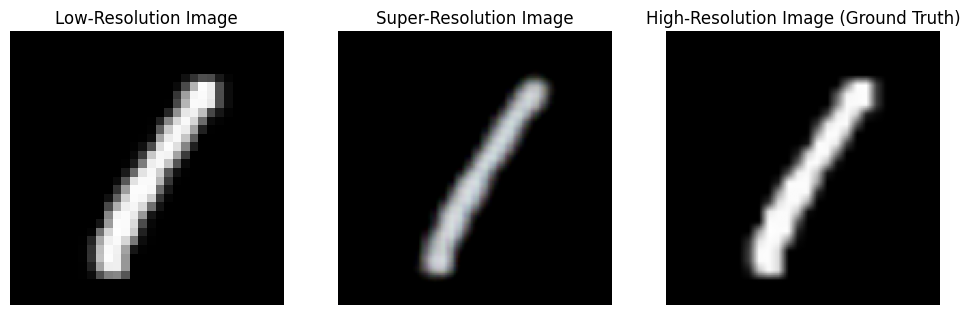

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.layers import PReLU  # Import PReLU

# Load the pre-trained generator model with custom_objects
generator = load_model('/content/drive/MyDrive/path_to_save_new/generator_model_epoch_360.h5',
                       custom_objects={'PReLU': PReLU}, compile=False)

# Assuming lr_test and hr_test are already defined from your training script
def test_and_visualize(lr_image, hr_image):
  """Tests the model and visualizes the results."""
  # Preprocess the low-resolution image (if necessary)
  lr_image = np.expand_dims(lr_image, axis=0)  # Add batch dimension

  # Generate the super-resolution image
  sr_image = generator.predict(lr_image)
  sr_image = np.squeeze(sr_image, axis=0)  # Remove batch dimension

  # Clip and convert the super-resolution image to uint8
  sr_image = np.clip(sr_image, 0, 1)  # Clip values to the range [0, 1]
  sr_image = (sr_image * 255).astype(np.uint8) # Scale to [0, 255] and convert to uint8


  # Visualize the results
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 3, 1)
  plt.title('Low-Resolution Image')
  plt.imshow(lr_image[0])  # Remove batch dimension for display
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title('Super-Resolution Image')
  plt.imshow(sr_image)
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title('High-Resolution Image (Ground Truth)')
  plt.imshow(hr_image)
  plt.axis('off')

  plt.show()

# Example usage:
test_image_index = 1  # Choose an image from your test set
test_and_visualize(lr_test[test_image_index], hr_test[test_image_index])

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/path_to_save_new/generator_model_epoch_360.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>